In [2]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4.

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)       
    
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu),stddev=1.0)
    return mu + tf.exp(log_var / 2) * eps

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))  
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 3
    size = height * width
    
    for i in range(mb_size):
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C))/(4. * (channels ** 2) * (size ** 2)))*1e0
    
    return loss_temp

def claps_loss(x):
    z_d_gen=backend.batch_flatten(x)          
    nom = tf.matmul(z_d_gen, tf.transpose(z_d_gen, perm=[1, 0]))
    denom = tf.sqrt(tf.reduce_sum(tf.square(z_d_gen), reduction_indices=[1], keep_dims=True))
    pt = tf.square(tf.transpose((nom / denom), (1, 0)) / denom)
    pt = pt - tf.diag(tf.diag_part(pt))
    pulling_term = tf.reduce_sum(pt) / (mb_size * (mb_size - 1))*10
    
    return pulling_term

def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/8, height/8, 1]), 
                                                  deconv2_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/8, height/8, deconv2_1_features]),deconv2_1_bias))

    h2_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_1,deconv2_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, height/4, deconv2_2_features]),deconv2_2_bias))    
    
    h3_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h2_2, deconv3_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/4, height/4, deconv3_1_features]),deconv3_1_bias))

    h3_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_1, deconv3_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, height/2, deconv3_2_features]),deconv3_2_bias))
    
    h4_1 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h3_2, deconv4_1_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, height/2, deconv4_1_features]),deconv4_1_bias))

    h4_2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(h4_1, deconv4_2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, height/1, deconv4_2_features]),deconv4_2_bias))    
    
    h5 = (tf.add(tf.nn.conv2d_transpose(h4_2, deconv5_weight, strides=[1, 1, 1, 1], padding='SAME',
                                        output_shape=[mb_size, width/1, height/1, 1]),deconv5_bias))
    
#     prob = tf.nn.sigmoid(h5)
    prob = 1 / (1 + tf.exp(-h5))
    
    return prob


def Q(X):
    h1_1 = tf.nn.relu(tf.add(conv2d(tf.reshape(X,[mb_size, width/1, height/1, 1]),
                                  conv1_1_weight, stride=1, padding='SAME'),conv1_1_bias))
    
    h1_2 = tf.nn.relu(tf.add(conv2d(h1_1,conv1_2_weight, stride=2, padding='SAME'),conv1_2_bias))
    
    h2_1 = tf.nn.relu(tf.add(conv2d(h1_2,conv2_1_weight, stride=1, padding='SAME'),conv2_1_bias))
    
    h2_2 = tf.nn.relu(tf.add(conv2d(h2_1,conv2_2_weight, stride=2, padding='SAME'),conv2_2_bias))

    h3_1 = tf.nn.relu(tf.add(conv2d(h2_2,conv3_1_weight, stride=1, padding='SAME'),conv3_1_bias))
    
    h3_2 = tf.nn.relu(tf.add(conv2d(h3_1,conv3_2_weight, stride=2, padding='SAME'),conv3_2_bias))    
    
    h4 = tf.nn.relu(tf.matmul(tf.reshape(h3_2,[mb_size,width/8*height/8*conv3_2_features]), Q_W1) + Q_b1)
    
    z_mu = (tf.matmul(h4, Q_W2_mu) + Q_b2_mu)
    z_logvar = (tf.matmul(h4, Q_W2_sigma) + Q_b2_sigma)
    
    return z_mu, z_logvar

In [3]:
######## loading input data ########
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import h5py
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.examples.tutorials.mnist import input_data


# images = abs(1-np.array(sio.loadmat('alloy_mat/WB_128_all_angle.mat')['WB'],dtype='float32'))
# images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young.mat')['L'],dtype='float32')

# images = (np.array(sio.loadmat('alloy_mat/sandstone_v2.mat')['Data'],dtype='float32'))
# images_L = np.array(sio.loadmat('alloy_mat/sandstone_v2_Young.mat')['L'],dtype='float32')

# images = np.array(sio.loadmat('alloy_mat/diffusion_coefficient_train.mat')['Data'],dtype='float32')
# images_L = np.array(sio.loadmat('alloy_mat/diffusion_coefficient_train.mat')['L'],dtype='float32')

images = np.array(sio.loadmat('alloy_mat/diffusion_coefficient_train_large.mat')['WB_large'],dtype='float32')

images=images[0:200]
# images_L=images_L[0:200]

mb_size = 10
X_dim = images.shape[1]
width = 128*2
height = 128*2
h_dim = width/8*height/8
z_dim = 128*2/8


conv1_1_features=32
conv1_2_features=32
conv2_1_features=32*2
conv2_2_features=32*2
conv3_1_features=32*3
conv3_2_features=32*3
conv4_features=1
c = 0

deconv2_1_features=32*3
deconv2_2_features=32*3
deconv3_1_features=32*2
deconv3_2_features=32*2
deconv4_1_features=32
deconv4_2_features=32

# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')

style_array = np.zeros([len(images),height,width,3])
style_array[:,:,:,0]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,1]=(images.reshape(len(images),height,width))*1
style_array[:,:,:,2]=(images.reshape(len(images),height,width))*1
print(style_array.shape)


Using TensorFlow backend.


(200, 256, 256, 3)


In [4]:
######## weights & bias loaading ########
f = h5py.File('weights_VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys()

vgg16_weights=[]
vgg16_bias=[]
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue

W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))
W_conv6 = (tf.constant(vgg16_weights[5]))
W_conv7 = (tf.constant(vgg16_weights[6]))
W_conv8 = (tf.constant(vgg16_weights[7]))
W_conv9 = (tf.constant(vgg16_weights[8]))
W_conv10= (tf.constant(vgg16_weights[9]))
W_conv11= (tf.constant(vgg16_weights[10]))
W_conv12= (tf.constant(vgg16_weights[11]))
W_conv13= (tf.constant(vgg16_weights[12]))

b_conv1 = tf.reshape(tf.constant(vgg16_bias[0]),[-1])
b_conv2 = tf.reshape(tf.constant(vgg16_bias[1]),[-1])
b_conv3 = tf.reshape(tf.constant(vgg16_bias[2]),[-1])
b_conv4 = tf.reshape(tf.constant(vgg16_bias[3]),[-1])
b_conv5 = tf.reshape(tf.constant(vgg16_bias[4]),[-1])
b_conv6 = tf.reshape(tf.constant(vgg16_bias[5]),[-1])
b_conv7 = tf.reshape(tf.constant(vgg16_bias[6]),[-1])
b_conv8 = tf.reshape(tf.constant(vgg16_bias[7]),[-1])
b_conv9 = tf.reshape(tf.constant(vgg16_bias[8]),[-1])
b_conv10 = tf.reshape(tf.constant(vgg16_bias[9]),[-1])
b_conv11 = tf.reshape(tf.constant(vgg16_bias[10]),[-1])
b_conv12 = tf.reshape(tf.constant(vgg16_bias[11]),[-1])
b_conv13 = tf.reshape(tf.constant(vgg16_bias[12]),[-1])

In [5]:
# =============================== Q(z|X) ======================================
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, height, 1)
X = tf.placeholder(tf.float32, shape=x_input_shape)
kl_ratio=tf.placeholder(tf.float32,shape=())

conv1_1_weight = tf.Variable(tf.truncated_normal([4, 4, 1, conv1_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_1_bias = tf.Variable(tf.zeros([conv1_1_features], dtype=tf.float32))

conv1_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_1_features, conv1_2_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_2_bias = tf.Variable(tf.zeros([conv1_2_features], dtype=tf.float32))

conv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_2_features,conv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_1_bias = tf.Variable(tf.zeros([conv2_1_features], dtype=tf.float32))

conv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_1_features,conv2_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv2_2_bias = tf.Variable(tf.zeros([conv2_2_features], dtype=tf.float32))

conv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_2_features,conv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
conv3_1_bias = tf.Variable(tf.zeros([conv3_1_features], dtype=tf.float32))

conv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_1_features,conv3_2_features],
                                               stddev=0.1, dtype=tf.float32))

conv3_2_bias = tf.Variable(tf.zeros([conv3_2_features], dtype=tf.float32))



Q_W1 = tf.Variable(xavier_init([X_dim/8/8*conv3_2_features, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

In [6]:
# =============================== P(X|z) ======================================
P_W1 = tf.Variable(xavier_init([z_dim, h_dim]),name="P_W1")
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]),name="P_b1")

deconv2_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_1_features, 1],
                                               stddev=0.1, dtype=tf.float32))
deconv2_1_bias = tf.Variable(tf.zeros([deconv2_1_features], dtype=tf.float32))

deconv2_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv2_2_features,deconv2_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv2_2_bias = tf.Variable(tf.zeros([deconv2_2_features], dtype=tf.float32))

deconv3_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_1_features, deconv2_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_1_bias = tf.Variable(tf.zeros([deconv3_1_features], dtype=tf.float32))

deconv3_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv3_2_features, deconv3_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv3_2_bias = tf.Variable(tf.zeros([deconv3_2_features], dtype=tf.float32))

deconv4_1_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_1_features, deconv3_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_1_bias = tf.Variable(tf.zeros([deconv4_1_features], dtype=tf.float32))

deconv4_2_weight = tf.Variable(tf.truncated_normal([4, 4, deconv4_2_features, deconv4_1_features],
                                               stddev=0.1, dtype=tf.float32))
deconv4_2_bias = tf.Variable(tf.zeros([deconv4_2_features], dtype=tf.float32))

deconv5_weight = tf.Variable(tf.truncated_normal([4, 4, 1, deconv4_2_features],
                                               stddev=0.1, dtype=tf.float32))
deconv5_bias = tf.Variable(tf.zeros([1], dtype=tf.float32))


In [7]:
# =============================== Middel Results ====================================
z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples_gen = P(z)


In [8]:
######## style transfer ########
style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

# z_mu_style, z_logvar_style = Q(style_image[:,:,:,0])

# z_sample_style = z_mu_style + tf.sqrt(tf.exp(z_logvar_style/2))*tf.random_normal([mb_size, z_dim])


X_samples = P(z)

combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*1
combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

In [14]:
# # =============================== Middel Results ====================================
# z_mu, z_logvar = Q(X)
# z_sample = sample_z(z_mu, z_logvar)
# prob = P(z_sample)

# # Sampling from random z
# X_samples = P(z)



In [15]:
# ######## style transfer ########
# combination_image_temp=tf.reshape(X_samples,[mb_size, height, width, 1])*1
# combination_image = tf.concat([combination_image_temp, combination_image_temp,combination_image_temp], 3)

# style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,3))

In [9]:
######### block 1 ########
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.relu(conv_out1)

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
conv_out3 = tf.nn.bias_add(conv_out3, b_conv3)
conv_out3 = tf.nn.relu(conv_out3)

conv_out4 = conv2d(conv_out3, W_conv4, stride=1, padding='SAME')
conv_out4 = tf.nn.bias_add(conv_out4, b_conv4)
conv_out4 = tf.nn.relu(conv_out4)
conv_out4 = max_pool(conv_out4, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5 = conv2d(conv_out4, W_conv5, stride=1, padding='SAME')
conv_out5 = tf.nn.bias_add(conv_out5, b_conv5)
conv_out5 = tf.nn.relu(conv_out5)

conv_out6 = conv2d(conv_out5, W_conv6, stride=1, padding='SAME')
conv_out6 = tf.nn.bias_add(conv_out6, b_conv6)
conv_out6 = tf.nn.relu(conv_out6)

conv_out7 = conv2d(conv_out6, W_conv7, stride=1, padding='SAME')
conv_out7 = tf.nn.bias_add(conv_out7, b_conv7)
conv_out7 = tf.nn.relu(conv_out7)
conv_out7 = max_pool(conv_out7, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8 = conv2d(conv_out7, W_conv8, stride=1, padding='SAME')
conv_out8 = tf.nn.bias_add(conv_out8, b_conv8)
conv_out8 = tf.nn.relu(conv_out8)

conv_out9 = conv2d(conv_out8, W_conv9, stride=1, padding='SAME')
conv_out9 = tf.nn.bias_add(conv_out9, b_conv9)
conv_out9 = tf.nn.relu(conv_out9)

conv_out10= conv2d(conv_out9, W_conv10, stride=1, padding='SAME')
conv_out10= tf.nn.bias_add(conv_out10, b_conv10)
conv_out10= tf.nn.relu(conv_out10)
conv_out10 = max_pool(conv_out10, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11= conv2d(conv_out10, W_conv11, stride=1, padding='SAME')
conv_out11= tf.nn.bias_add(conv_out11, b_conv11)
conv_out11= tf.nn.relu(conv_out11)

conv_out12= conv2d(conv_out11, W_conv12, stride=1, padding='SAME')
conv_out12= tf.nn.bias_add(conv_out12, b_conv12)
conv_out12= tf.nn.relu(conv_out12)

conv_out13= conv2d(conv_out12, W_conv13, stride=1, padding='SAME')
conv_out13= tf.nn.bias_add(conv_out13, b_conv12)
conv_out13= tf.nn.relu(conv_out13)

In [10]:
######### block 1 ########
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.relu(conv_out1_S)

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

######### block 2 ########
conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
conv_out3_S = tf.nn.bias_add(conv_out3_S, b_conv3)
conv_out3_S = tf.nn.relu(conv_out3_S)

conv_out4_S = conv2d(conv_out3_S, W_conv4, stride=1, padding='SAME')
conv_out4_S = tf.nn.bias_add(conv_out4_S, b_conv4)
conv_out4_S = tf.nn.relu(conv_out4_S)
conv_out4_S = max_pool(conv_out4_S, k_size=2, stride=2, padding="SAME")

######### block 3 ########
conv_out5_S = conv2d(conv_out4_S, W_conv5, stride=1, padding='SAME')
conv_out5_S = tf.nn.bias_add(conv_out5_S, b_conv5)
conv_out5_S = tf.nn.relu(conv_out5_S)

conv_out6_S = conv2d(conv_out5_S, W_conv6, stride=1, padding='SAME')
conv_out6_S = tf.nn.bias_add(conv_out6_S, b_conv6)
conv_out6_S = tf.nn.relu(conv_out6_S)

conv_out7_S = conv2d(conv_out6_S, W_conv7, stride=1, padding='SAME')
conv_out7_S = tf.nn.bias_add(conv_out7_S, b_conv7)
conv_out7_S = tf.nn.relu(conv_out7_S)
conv_out7_S = max_pool(conv_out7_S, k_size=2, stride=2, padding="SAME")

######### block 4 ########
conv_out8_S = conv2d(conv_out7_S, W_conv8, stride=1, padding='SAME')
conv_out8_S = tf.nn.bias_add(conv_out8_S, b_conv8)
conv_out8_S = tf.nn.relu(conv_out8_S)

conv_out9_S = conv2d(conv_out8_S, W_conv9, stride=1, padding='SAME')
conv_out9_S = tf.nn.bias_add(conv_out9_S, b_conv9)
conv_out9_S = tf.nn.relu(conv_out9_S)

conv_out10_S= conv2d(conv_out9_S, W_conv10, stride=1, padding='SAME')
conv_out10_S= tf.nn.bias_add(conv_out10_S, b_conv10)
conv_out10_S= tf.nn.relu(conv_out10_S)
conv_out10_S= max_pool(conv_out10_S, k_size=2, stride=2, padding="SAME")

######### block 5 ########
conv_out11_S= conv2d(conv_out10_S, W_conv11, stride=1, padding='SAME')
conv_out11_S= tf.nn.bias_add(conv_out11_S, b_conv11)
conv_out11_S= tf.nn.relu(conv_out11_S)

conv_out12_S= conv2d(conv_out11_S, W_conv12, stride=1, padding='SAME')
conv_out12_S= tf.nn.bias_add(conv_out12_S, b_conv12)
conv_out12_S= tf.nn.relu(conv_out12_S)

conv_out13_S= conv2d(conv_out12_S, W_conv13, stride=1, padding='SAME')
conv_out13_S= tf.nn.bias_add(conv_out13_S, b_conv13)
conv_out13_S= tf.nn.relu(conv_out13_S)

In [11]:
# =============================== latent to Young's Module ====================================
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with linear activation
    out_layer = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([z_dim, z_dim/4])),
    'h2': tf.Variable(tf.random_normal([z_dim/4, 1])),
}

biases = {
    'b1': tf.Variable(tf.random_normal([z_dim/4])),
    'b2': tf.Variable(tf.random_normal([1])),
}

label = tf.placeholder(tf.float32, shape=[None, 1])
pred = multilayer_perceptron(z_sample, weights, biases)

In [12]:
# =============================== Cost ====================================

# Style transfer
sl1 = style_loss(conv_out2_S,conv_out2)
sl2 = style_loss(conv_out4_S,conv_out4)
sl3 = style_loss(conv_out1_S,conv_out1)
sl4 = style_loss(conv_out3_S,conv_out3)
sl = (sl1 + sl2 + sl3 + sl4)/1e0

# Young's modulus cost
# Young_cost = tf.reduce_mean(tf.square(pred - label))*0

# claps cost
cl1 = claps_loss(conv_out2)
cl2 = claps_loss(conv_out4)
cl3 = claps_loss(conv_out1)
cl4 = claps_loss(conv_out3)
cl = (cl1+cl2+cl3+cl4)*1e0

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/1e0

# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian

kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))*kl_ratio

# VAE loss
# vae_loss = tf.reduce_mean(recon_loss + kl_loss + cl + Young_cost + sl)
vae_loss = tf.reduce_mean(recon_loss + kl_loss + cl + sl)


In [13]:
import random
solver = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(vae_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
kl_ratio_initial=1e0
PC_ori=[]
saver = tf.train.Saver()
cl_E_store=[]
kl_E_store=[]
for it in range(10000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
#     Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    random_index=random.sample(range(len(style_array)),  mb_size)
    style_array_input = style_array[random_index]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E, sl_E, sl_E1,sl_E2,sl_E3,sl_E4 = sess.run([solver, vae_loss, recon_loss, kl_loss,
                                                                             cl, sl, sl1, sl2, sl3, sl4],
                                                           feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                                           style_image: style_array_input.reshape(mb_size,height,width,3),
                                                           z: np.random.randn(mb_size, z_dim),
                                                           kl_ratio:kl_ratio_initial})

    
    if recon_E <=2e2:
        kl_ratio_initial=5e1
#     if recon_E <=2e3:
#         kl_ratio_initial=2e1        
        
    cl_E_store.append(cl_E)
    kl_E_store.append(kl_E)
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
        print('sl_E1:{}'.format(sl_E1))
        print('sl_E2:{}'.format(sl_E2))
        print('sl_E3:{}'.format(sl_E3))
        print('sl_E4:{}'.format(sl_E4))
        
        print()


Iter: 0
Loss: 33754.4609375
recon_E:28776.0058594
kl_E:123.262023926
cl_E:33.4727401733
sl_E:4821.72021484
sl_E1:329.506317139
sl_E2:1967.57775879
sl_E3:24.5687522888
sl_E4:2500.06738281
()
Iter: 100
Loss: 9191.04101562
recon_E:7946.93457031
kl_E:56.3619880676
cl_E:34.1039428711
sl_E:1153.64038086
sl_E1:33.7337188721
sl_E2:629.985900879
sl_E3:1.4240500927
sl_E4:488.496765137
()
Iter: 200
Loss: 7532.19628906
recon_E:7029.52441406
kl_E:39.9167175293
cl_E:36.7773361206
sl_E:425.978088379
sl_E1:27.049161911
sl_E2:182.511138916
sl_E3:1.92490041256
sl_E4:214.492889404
()
Iter: 300
Loss: 7109.10595703
recon_E:6743.42578125
kl_E:43.6111984253
cl_E:37.5746040344
sl_E:284.49407959
sl_E1:20.286945343
sl_E2:111.65247345
sl_E3:1.48371756077
sl_E4:151.070953369
()
Iter: 400
Loss: 7070.27539062
recon_E:6649.88867188
kl_E:45.1483917236
cl_E:37.8972587585
sl_E:337.3409729
sl_E1:32.7591133118
sl_E2:106.110267639
sl_E3:2.49525904655
sl_E4:195.976333618
()
Iter: 500
Loss: 6888.65429688
recon_E:6454.932617

In [1]:
1

1

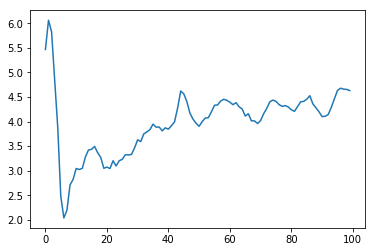

In [15]:
%matplotlib inline
plt.plot(np.log(kl_E_store))

In [65]:
save_path = saver.save(sess, "Hechao_Data/model_hechao_deeper_vali_model_adjusted.ckpt")

In [14]:
# save_path = saver.save(sess, "Hechao_Data/model_hechao_deeper.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "Hechao_Data/model_hechao_deeper_vali_version2.ckpt")

for it in range(100000):
    X_mb = images[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    Y_L = images_L[(it*mb_size)%len(images):(it*mb_size)%len(images)+mb_size]
    style_array_input = style_array[random.sample(range(len(style_array)),  mb_size)]
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E,cl_E, sl_E,Young_E, sl_E1,sl_E2,sl_E3,sl_E4 = sess.run([solver, vae_loss, recon_loss, kl_loss,
                                                                             cl, sl, Young_cost, sl1, sl2, sl3, sl4],
                                                           feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
                                                           label:Y_L.reshape(mb_size,1),
                                                           style_image: style_array_input.reshape(mb_size,128,128,3),
                                                           z: np.random.randn(mb_size, z_dim)})

    
    
    cl_E_store.append(cl_E)
    if it % 200 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('Young_E:{}'.format(Young_E))
        print('cl_E:{}'.format(cl_E))
        print('sl_E:{}'.format(sl_E))
        print('sl_E1:{}'.format(sl_E1))
        print('sl_E2:{}'.format(sl_E2))
        print('sl_E3:{}'.format(sl_E3))
        print('sl_E4:{}'.format(sl_E4))
        
        print()

INFO:tensorflow:Restoring parameters from Hechao_Data/model_hechao_deeper_vali_version2.ckpt


NameError: name 'cl_E_store' is not defined

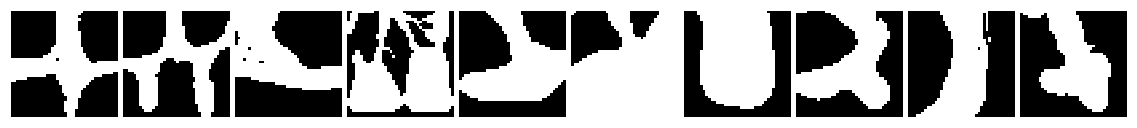

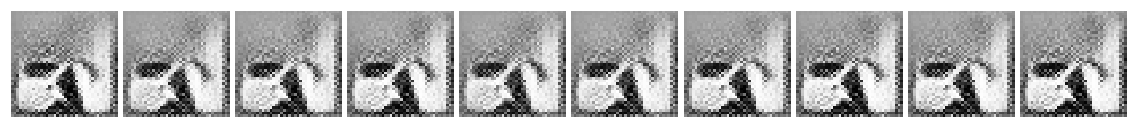

In [16]:
%matplotlib inline
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(40, 40), cmap='Greys_r')

X_mb = images[0:mb_size]
recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
plot(images[0:10])
plot(recon[0:10])

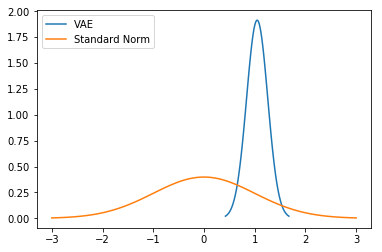

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
%matplotlib inline

test_mu,test_logvar=sess.run([z_mu, z_logvar],feed_dict={X: X_mb.reshape(mb_size, width, height, 1),
#                                                            label:Y_L.reshape(mb_size,1),
                                                           style_image: style_array_input.reshape(mb_size,40,40,3),
                                                           z: np.random.randn(mb_size, z_dim)})

mu = np.mean(test_mu)
var= np.mean(np.exp(test_logvar))
sigma = math.sqrt(var)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma),label='VAE')

x = np.linspace(0 - 3*1, 0 + 3*1, 100)
plt.plot(x,mlab.normpdf(x, 0, 1),label='Standard Norm')
plt.legend()
plt.show()

In [210]:
sio.savemat('Hechao_Data/Reconstruction.mat',mdict={'recon':recon})

(array([  8.,   9.,   2.,   0.,   1.,  15.,  27.,   6.,  12.,  20.]),
 array([-4.6345048 , -4.00802354, -3.38154228, -2.75506102, -2.12857976,
        -1.5020985 , -0.87561724, -0.24913598,  0.37734528,  1.00382653,
         1.63030779]),
 <a list of 10 Patch objects>)

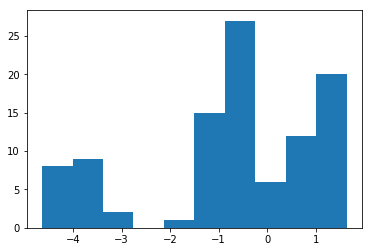

In [27]:
%matplotlib inline
X_mb = images[0:mb_size]
latent_z = sess.run(z_sample,feed_dict={X: X_mb.reshape(mb_size, width, height, 1)})
plt.hist(latent_z.reshape(-1))

(array([  2.,   6.,  10.,   9.,  16.,  24.,  15.,   9.,   4.,   5.]),
 array([-2.63874328, -2.13805629, -1.6373693 , -1.13668231, -0.63599532,
        -0.13530833,  0.36537865,  0.86606564,  1.36675263,  1.86743962,
         2.36812661]),
 <a list of 10 Patch objects>)

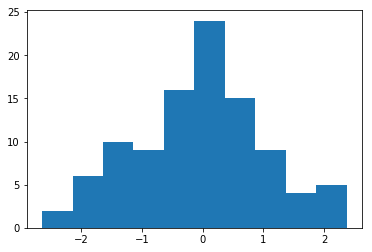

In [25]:
test=np.random.randn(mb_size, z_dim)
plt.hist(test.reshape(-1))

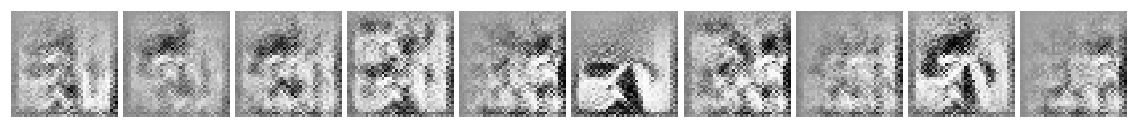

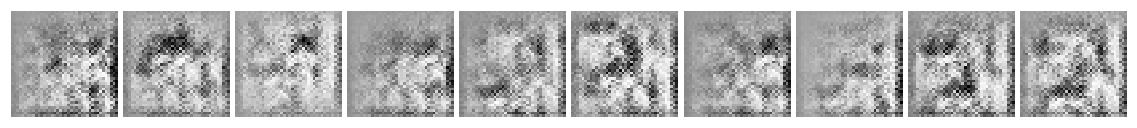

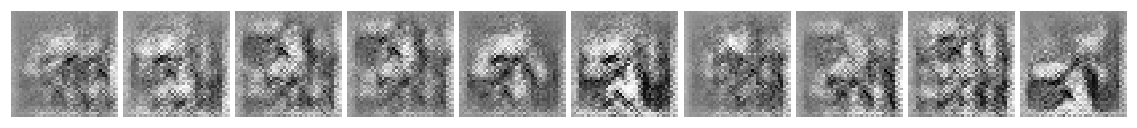

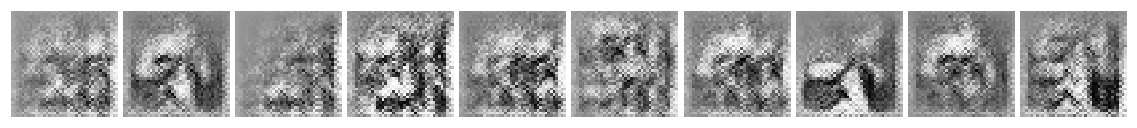

In [20]:
####### Random Generation
%matplotlib inline
samples = abs(sess.run(X_samples_gen, feed_dict={z: np.random.randn(mb_size, z_dim)}))
# samples[samples>0.5]=1
# samples[samples<=0.5]=0
plot(samples[0:10])
plot(samples[10:20])
samples = abs(1-sess.run(X_samples_gen, feed_dict={z: np.random.randn(mb_size, z_dim)}))
# samples[samples>0.5]=1
# samples[samples<=0.5]=0
plot(samples[0:10])
plot(samples[10:20])

In [61]:
####### Random Generation
%matplotlib inline
xtr=np.zeros([mb_size*50,width,height,1])
samples = sess.run(X_samples_gen, feed_dict={z: np.random.randn(mb_size, z_dim)/1})

k=0
for i in range(50):  
    samples = sess.run(X_samples_gen, feed_dict={z: np.random.randn(mb_size, z_dim)/1})
    xtr[k*mb_size:k*mb_size+mb_size,:,:,:]=samples
    k=k+1

In [62]:
xtr.shape

(1000, 128, 128, 1)

In [63]:
sio.savemat('Hechao_Data/Random_Generation_T400V100T100_1000samples.mat',mdict={'samples':xtr})

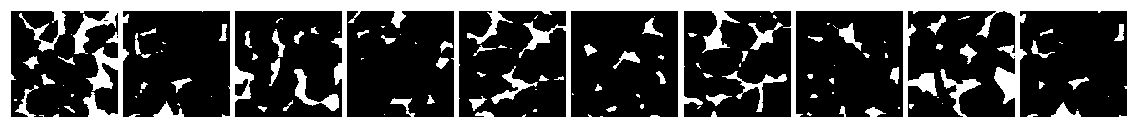

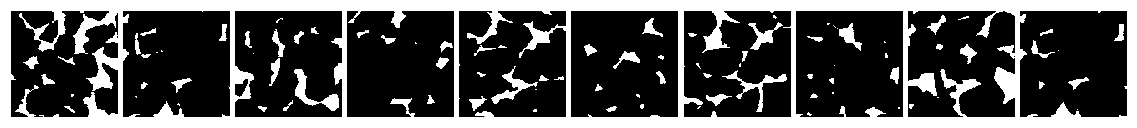

In [39]:
# =============================== Validation(Samples that can't predict well) ====================================
images_test_index = (sio.loadmat('Hechao_Data/large_error_validation_index.mat')['index'])+32
images_test = images[images_test_index.reshape(-1)]

X_mb_test=images_test[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb_test.reshape(mb_size, width, height, 1)})
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(X_mb_test[0:10])
plot(sample_temp[0:10])

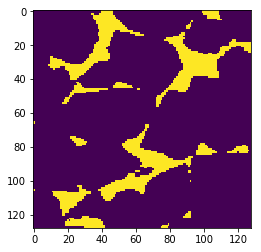

In [51]:
plt.imshow(images[128+32].reshape(128,128))

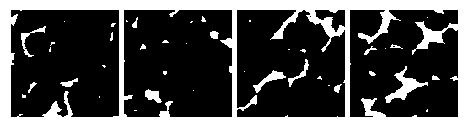

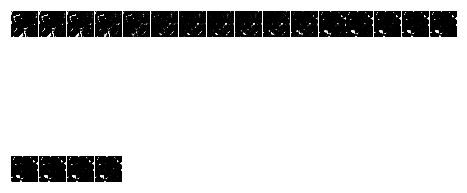

In [82]:
# =============================== Modification on Hard Samples ====================================
# 90 index, we pick the first 80 and leave the rest 10 for future validation
def plot_mid(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(3, mid_res)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')
    
def plot_ori(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(1, 4)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')


images_test_index = (sio.loadmat('Hechao_Data/large_error_validation_400T100V100T_26index_selected_version3.mat')
                     ['index'])
images_diff = images[images_test_index.reshape(-1)]

mid_res=16 # number of generation between two samples


z_store=np.zeros([(len(images_diff)-1)*mid_res,16])

for ii in range(len(images_diff)-mb_size+1):
    X_mb = images_diff[ii:ii+mb_size]
    z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})
    for i in range(mb_size-1):  
        step=(z_temp[i+1]-z_temp[i])/(mid_res+1.)
        for j in range(mid_res):
            z_store_temp=z_temp[i]+step*(j+1)
            z_store[(i+ii)*mid_res+j,:]=z_store_temp
#             print((i+ii)*mid_res+j)

##### show example #####
z_store_test=np.array(z_store[0:mb_size])    
sample_generation=sess.run(X_samples_gen, feed_dict={z: z_store_test})
plot_ori(images_diff[0:mb_size].reshape(mb_size, width, height, 1)[0:4])
plot_mid(sample_generation[0:3*mid_res])
    

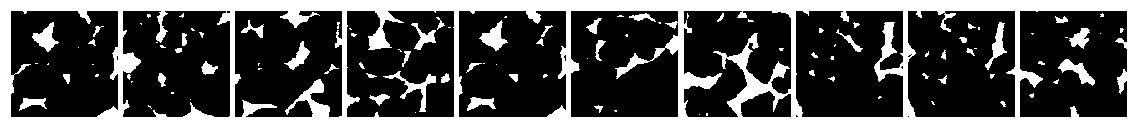

In [78]:
plot(images[images_test_index.reshape(-1)][-10:])

In [64]:
# sample_store=[]
# z_store=np.array(z_store) 
# for i in range(len(z_store)/mb_size):
#     sample_generation=sess.run(X_samples, feed_dict={z: z_store[i*mb_size:(i+1)*mb_size,:]})
#     sample_store.append(sample_generation)

# sample_total=sample_store[0]
# for i in range(1,len(sample_store)):
#     sample_total=np.concatenate((sample_total, sample_store[i]), axis=0)
    
# sio.savemat('Hechao_Data/Generation_Interpo4_selected26_large_error_validation_based_T400V100T100_400samples.mat',
#             mdict={'sample_total':sample_total})

In [83]:
sample_store=np.zeros([len(z_store),128,128,1])
z_store=np.array(z_store) 
for i in range(len(z_store)-mb_size+1):
    sample_generation=sess.run(X_samples_gen, feed_dict={z: z_store[i:i+mb_size,:]})
    sample_store[i:i+mb_size,:,:,:]=sample_generation   
    
sio.savemat('Hechao_Data/Generation_newmodel_selected26index_large_error_interpo_T400V100T100_400samples.mat',
            mdict={'sample_total':sample_store})

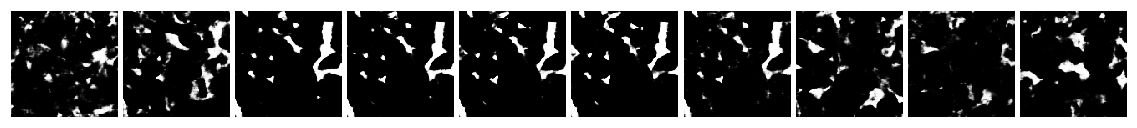

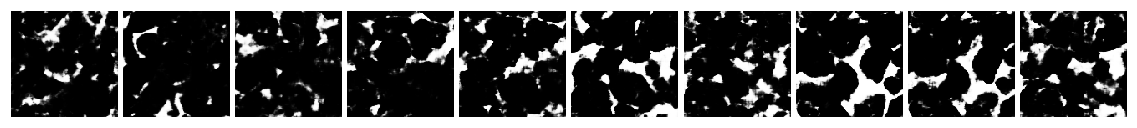

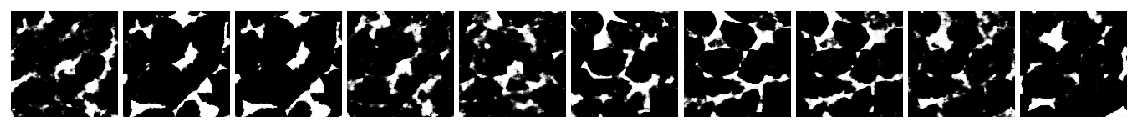

In [74]:
plot(sample_store[-10:])
plot(sample_store[-20:-10])
plot(sample_store[-30:-20])

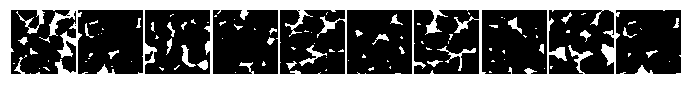

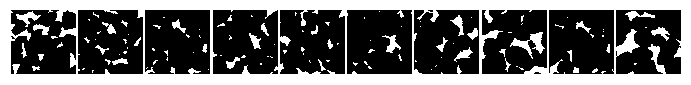

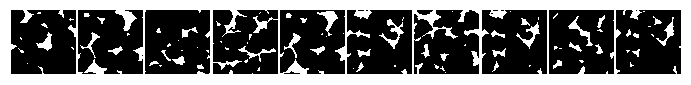

In [46]:
def plot(samples):
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(1, 10)
    gs.update(wspace=0.05, hspace=0.0)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
#         ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')
    
plot(images_diff[0:10])
plot(images_diff[10:20])
plot(images_diff[20:30])

In [1]:
import scipy.io as sio
import numpy as np
images_hechao = np.array(sio.loadmat('Hechao_Data/Generation_test.mat')['sample_store'],dtype='float32')

In [48]:
z_temp.shape

(20, 16)

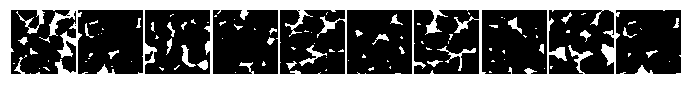

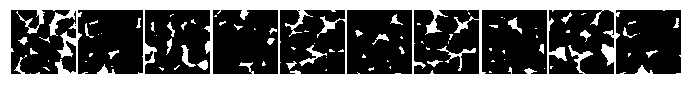

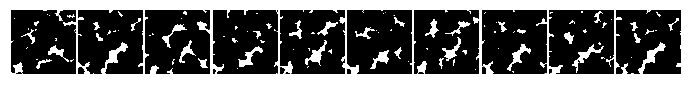

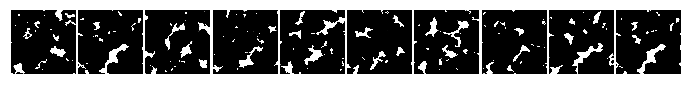

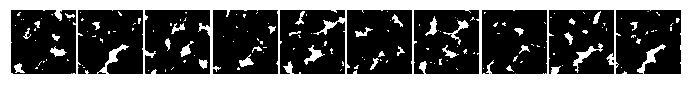

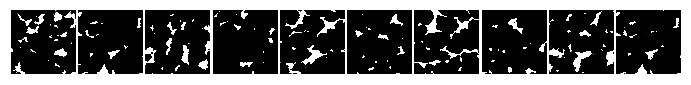

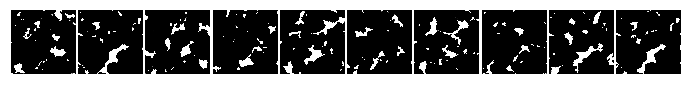

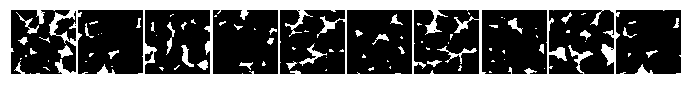

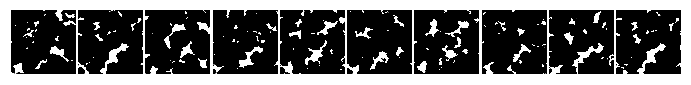

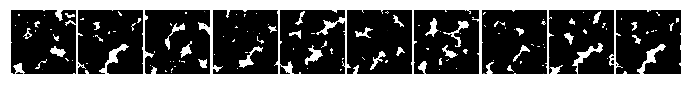

In [47]:
# =============================== Modification on Hard Samples ====================================
# images_index = np.array(sio.loadmat('alloy_mat/diff_fig.mat')['index'],dtype='float32')

images_test_index = (sio.loadmat('Hechao_Data/large_error_validation_index.mat')['index'])+32
images_diff = images[images_test_index.reshape(-1)]

X_mb = images_diff[0:mb_size]
# recon = sess.run(prob,feed_dict={X: X_mb.reshape(mb_size, width, height, num_channels_1),
#                                  label:Y_L.reshape(mb_size,1)})

xtr=np.zeros([mb_size*10,width,height,1])
k=0
for i in range(10):  
    z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, height, 1)})
    
    rand_index=random.sample(np.arange(16),16)
    z_temp[:,rand_index]=z_temp[:,rand_index]+random.random()/1 
    
    sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
    xtr[k*mb_size:k*mb_size+mb_size,:,:,:]=sample_temp
    k=k+1
    
plot(X_mb[0:10])
plot(xtr[0:10])
plot(xtr[20:30])
plot(xtr[40:50])
plot(xtr[60:70])
plot(xtr[80:90])
plot(xtr[100:110])
plot(xtr[120:130])
plot(xtr[140:150])
plot(xtr[160:170])